<a href="https://colab.research.google.com/github/Uniholder/DeepLearningSchool/blob/main/14_3D_ML_project/Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Зависимости для frankmocap

In [ ]:
!pip install torch==1.6.0 torchvision==0.7.0

In [ ]:
!sudo apt-get install ffmpeg libosmesa6-dev
!git clone https://github.com/facebookresearch/frankmocap.git 
!pip install -r frankmocap/docs/requirements.txt 
!pip install pytorch3d
!(cd frankmocap/ && sh scripts/install_frankmocap.sh) 
!mkdir frankmocap/extra_data/smpl/ 
!gdown --id 1t4tvZCbRT37iBOpVCoOBHHQ4D6KsOAz3 -O frankmocap/extra_data/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
!gdown --id 10cEgesBBsd-NyDyCUsvYoA58TQXynjJT -O frankmocap/extra_data/smpl/SMPLX_NEUTRAL.pkl
# !gdown --id 1hdUSTIQlwasSh41sGTockNApgINNEXGG -O frankmocap/extra_data/smpl/J_regressor_extra_smplx.npy
# !gdown --id 16kMiHFR0BUxc3AcWUdm46DdOA0ieOVP8 # -O smplx-03-28-46060-w_spin_mlc3d_46582-2089_2020_03_28-21_56_16.pt
!sudo apt-get install -y xvfb
!pip install torchgeometry

Зависимости для MGN

In [ ]:
!git clone https://github.com/bharat-b7/MultiGarmentNetwork.git
!wget https://datasets.d2.mpi-inf.mpg.de/MultiGarmentNetwork/Multi-Garmentdataset.zip
!unzip Multi-Garmentdataset.zip
!rm Multi-Garmentdataset.zip
!wget https://datasets.d2.mpi-inf.mpg.de/MultiGarmentNetwork/Multi-Garmentdataset_02.zip
!unzip Multi-Garmentdataset_02.zip
!rm Multi-Garmentdataset_02.zip
!gdown --id 1t4tvZCbRT37iBOpVCoOBHHQ4D6KsOAz3 -O MultiGarmentNetwork/assets/neutral_smpl.pkl
!git clone https://github.com/pmh47/dirt.git
!sed -i 's|set(CMAKE_CUDA_FLAGS "${CMAKE_CUDA_FLAGS} -arch=sm_30 --expt-relaxed-constexpr -DNDEBUG")|set(CMAKE_CUDA_FLAGS "${CMAKE_CUDA_FLAGS} -arch=sm_60 --expt-relaxed-constexpr -DNDEBUG")|' dirt/csrc/CMakeLists.txt
!(cd dirt && pip install .)
!git clone https://github.com/MPI-IS/mesh.git
!sudo apt-get install libboost-dev # don't need on colab
!(cd mesh/ && BOOST_INCLUDE_DIRS=/usr/lib/x86_64-linux-gnu/ make all)
!wget https://datasets.d2.mpi-inf.mpg.de/MultiGarmentNetwork/weights.zip
!unzip weights.zip
!rm weights.zip
!mv Multi-Garment\ Network/test_data.pkl MultiGarmentNetwork/test_data.pkl
!mv Multi-Garment\ Network/saved_model/ MultiGarmentNetwork/saved_model/
!mv Multi-Garment\ Network/assets/* MultiGarmentNetwork/assets/
!rm -r Multi-Garment\ Network/
!sudo apt-get install -y xvfb
!sed -i "s|import cPickle as pkl|import _pickle as pkl|" MultiGarmentNetwork/visualize_scan.py
!sed -i "s|/BS/bharat/work/MGN_release/||" MultiGarmentNetwork/visualize_scan.py
!sed -i "s|scan.show()|scan.show().save_snapshot('scan.png', blocking=True)|" MultiGarmentNetwork/visualize_scan.py
!sed -i "s|scan2.show()|scan2.show().save_snapshot('scan2.png', blocking=True)|" MultiGarmentNetwork/visualize_scan.py
!find ./ -type f -name "*.py" -exec sed -i 's|import cPickle as pkl|import _pickle as pkl|' {} \;
!find ./ -type f -name "*.py" -exec sed -i 's|import cPickle as pickle|import _pickle as pickle|' {} \;
!sudo apt-get install -qq libboost-dev xvfb libosmesa6-dev
!pip install chumpy opendr
!find ./ -type f -name "*.py" -exec sed -i "s|from verts|from .verts|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|^import lbs$|from . import lbs|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|from posemapper|from .posemapper|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|from serialization|from .serialization|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|/BS/bharat/work/MGN_final_release/|MultiGarmentNetwork/|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|/BS/RVH/work/data/smpl_models/neutral/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl|MultiGarmentNetwork/assets/neutral_smpl.pkl|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|/BS/bharat/work/MGN_release/||" {} \;
!find ./ -type f -name "*.py" -exec sed -i -r s/pkl\.load[\(]open[\(]\(.+\)[\)][\)]/pkl.load\(open\(\\1,\ \'rb\'\)\ ,\ encoding=\'latin1\'\)/g  {} \;

In [5]:
!sed -i "s|mvs\[0\]\[1\].set_static_meshes(\[garment_org_body\])|mvs\[0\]\[1\].set_static_meshes(\[garment_org_body\]); mvs\[0\]\[1\].save_snapshot('garment_org_body.png', blocking=True)|" MultiGarmentNetwork/visualize_garments.py
!sed -i "s|mvs\[0\]\[2\].set_static_meshes(\[garment_org_body, garment_posed\])|mvs\[0\]\[2\].set_static_meshes(\[garment_org_body, garment_posed\]); mvs\[0\]\[2\].save_snapshot('garment_org_body_garment_posed.png', blocking=True)|" MultiGarmentNetwork/visualize_garments.py
!sed -i "s|mvs\[0\]\[0\].set_static_meshes(\[garment_unposed\])|mvs\[0\]\[0\].set_static_meshes(\[garment_unposed\]); mvs\[0\]\[0\].save_snapshot('garment_unposed.png', blocking=True)|" MultiGarmentNetwork/visualize_garments.py
!find ./ -type f -name "*.py" -exec sed -i "s|assets/garment_fts.pkl|MultiGarmentNetwork/assets/garment_fts.pkl|" {} \;
!mv MultiGarmentNetwork/ frankmocap/

In [6]:
%cd frankmocap/

/content/frankmocap


In [2]:
import os
import sys
import os.path as osp
import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json
import _pickle as pkl
from datetime import datetime

from demo.demo_options import DemoOptions
from bodymocap.body_mocap_api import BodyMocap
from bodymocap.body_bbox_detector import BodyPoseEstimator
import mocap_utils.demo_utils as demo_utils
import mocap_utils.general_utils as gnu
from mocap_utils.timer import Timer

import renderer.image_utils as imu
from renderer.screen_free_visualizer import Visualizer
from renderer import p3d_renderer

from mocap_utils.coordconv import convert_smpl_to_bbox, convert_bbox_to_oriIm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
!find ./ -type f -name "*.py" -exec sed -i "s|from lib|from MultiGarmentNetwork.lib|" {} \;
!find ./ -type f -name "*.py" -exec sed -i "s|from utils|from MultiGarmentNetwork.utils|" {} \;

In [8]:
from os.path import exists, join, split
from glob import glob
from psbody.mesh import Mesh, MeshViewer, MeshViewers

from MultiGarmentNetwork.utils.smpl_paths import SmplPaths
from MultiGarmentNetwork.lib.ch_smpl import Smpl
from MultiGarmentNetwork.dress_SMPL import load_smpl_from_file, pose_garment, dress
from MultiGarmentNetwork.utils.interpenetration_ind import remove_interpenetration_fast

from IPython.display import Image

In [29]:
# Set bbox detector
body_bbox_detector = BodyPoseEstimator()

use_smplx = False # штаны съезжают в smplx

# Set mocap regressor
if use_smplx:
    checkpoint_path = './extra_data/body_module/pretrained_weights/smplx-03-28-46060-w_spin_mlc3d_46582-2089_2020_03_28-21_56_16.pt'
else:
    checkpoint_path = './extra_data/body_module/pretrained_weights/2020_05_31-00_50_43-best-51.749683916568756.pt'
smpl_dir = './extra_data/smpl/'
body_mocap = BodyMocap(checkpoint_path, smpl_dir, device, use_smplx=use_smplx)

visualizer = Visualizer('pytorch3d')

Loading Body Pose Estimator


In [23]:
# MGN
path = '../Multi-Garment_dataset/'
garment_classes = ['Pants', 'ShortPants', 'ShirtNoCoat', 'TShirtNoCoat', 'LongCoat']
gar_dict = {}
for gar in garment_classes:
    gar_dict[gar] = glob(join(path, '*', gar + '.obj'))

dp = SmplPaths()
# vt, ft = dp.get_vt_ft_hres()
smpl = Smpl(dp.get_hres_smpl_model_data())

## This file contains correspondances between garment vertices and smpl body
fts_file = 'MultiGarmentNetwork/assets/garment_fts.pkl'
vert_indices, fts = pkl.load(open(fts_file, 'rb') , encoding='latin1')
# fts['naked'] = ft

## Choose any garmet type as source
garment_type = 'ShirtNoCoat'
index = np.random.randint(0, len(gar_dict[garment_type]))   ## Randomly pick from the digital wardrobe
path = split(gar_dict[garment_type][index])[0]
    
garment_org_body_unposed = load_smpl_from_file(join(path, 'registration.pkl'))
garment_org_body_unposed.pose[:] = 0
garment_org_body_unposed.trans[:] = 0
garment_org_body_unposed = Mesh(garment_org_body_unposed.v, garment_org_body_unposed.f)

garment_unposed = Mesh(filename=join(path, garment_type + '.obj'))
garment_tex = join(path, 'multi_tex.jpg')
# tgt_body = Mesh(smpl.r, smpl.f)

vert_inds = vert_indices[garment_type]
garment_unposed.set_texture_image(garment_tex)

In [62]:
pred_vertices_img.shape

(9723, 3)

In [69]:
torch.from_numpy(np.array([0.8, 0.53, 0.53])[::-1].copy()).view(1, 1, 3).float().repeat(1, pred_vertices_img.shape[0], 1)

tensor([[[0.5300, 0.5300, 0.8000],
         [0.5300, 0.5300, 0.8000],
         [0.5300, 0.5300, 0.8000],
         ...,
         [0.5300, 0.5300, 0.8000],
         [0.5300, 0.5300, 0.8000],
         [0.5300, 0.5300, 0.8000]]])

In [70]:
torch.from_numpy(np.array([0.8, 0.53, 0.53])[::-1].copy()).view(1, 1, 3).float().repeat(1, pred_vertices_img.shape[0], 1).shape

torch.Size([1, 9723, 3])

In [73]:
new_garment.v.shape

(9723, 3)

In [77]:
new_garment.texture_image.shape

(2048, 2048, 3)

In [80]:
len(new_garment.texture_coordinates_by_vertex())

9723

In [131]:
new_garment.texture_coordinates_by_vertex()[0][:]

[array([0.387513, 0.507169]),
 array([0.387513, 0.507169]),
 array([0.387513, 0.507169]),
 array([0.387513, 0.507169]),
 array([0.387513, 0.507169]),
 array([0.387513, 0.507169])]

In [ ]:
np.array([np.array(xi) for xi in x])

In [121]:
np.asarray(new_garment.texture_coordinates_by_vertex(), dtype=object)

array([list([array([0.387513, 0.507169]), array([0.387513, 0.507169]), array([0.387513, 0.507169]), array([0.387513, 0.507169]), array([0.387513, 0.507169]), array([0.387513, 0.507169])]),
       list([array([0.405413, 0.510688]), array([0.405413, 0.510688]), array([0.405413, 0.510688]), array([0.405413, 0.510688]), array([0.405413, 0.510688]), array([0.405413, 0.510688])]),
       list([array([0.404663, 0.519413]), array([0.404663, 0.519413]), array([0.404663, 0.519413]), array([0.404663, 0.519413]), array([0.404663, 0.519413]), array([0.404663, 0.519413])]),
       ...,
       list([array([0.241538, 0.38375 ]), array([0.241538, 0.38375 ]), array([0.241538, 0.38375 ]), array([0.241538, 0.38375 ]), array([0.241538, 0.38375 ]), array([0.241538, 0.38375 ])]),
       list([array([0.246625, 0.38065 ]), array([0.246625, 0.38065 ]), array([0.246625, 0.38065 ]), array([0.246625, 0.38065 ]), array([0.246625, 0.38065 ]), array([0.246625, 0.38065 ])]),
       list([array([0.24305 , 0.379062]), a

In [96]:
new_garment.v.shape

(9723, 3)

In [89]:
new_garment.v[0]

array([ 0.07686935, -0.72574234, -0.08234009])

In [95]:
new_garment.vt.shape

(28920, 2)

In [102]:
new_garment.texture_rgb([0.371925, 0.881562])

array([171., 125., 101.])

In [110]:
new_garment.texture_rgb_vec(np.array([[0.405413, 0.510688]]))

array([[123, 126, 119]], dtype=uint8)

In [30]:
%%time
start_frame = 0
cur_frame = start_frame
video_frame = 0
timer = Timer()

class Args():
    def __init__(self):
        self.input_path = './sample_data/han_short.mp4'
        self.input_type = 'video'
        self.save_frame = False
        self.out_dir = './mocap_output'
        self.end_frame = float('inf')
        self.save_bbox_output = False
        self.single_person = False
        self.no_display = True
        self.save_pred_pkl = True
        self.use_smplx = True
        self.save_mesh = True
        self.no_video_out = False

args = Args()

use_smplx = args.use_smplx
        
input_type, input_data = demo_utils.setup_input(args)

while True:
    timer.tic()
    # load data
    if input_type == 'video':      
        _, img_original_bgr = input_data.read()
        if video_frame < cur_frame:
            video_frame += 1
            continue
        # save the obtained video frames
        image_path = osp.join(args.out_dir, "frames", f"{cur_frame:05d}.jpg")
        if img_original_bgr is not None:
            video_frame += 1
            if args.save_frame:
                gnu.make_subdir(image_path)
                cv2.imwrite(image_path, img_original_bgr)
    else:
        assert False, "Unknown input_type"

    cur_frame +=1
    if img_original_bgr is None or cur_frame > args.end_frame:
        break   
    print("--------------------------------------")

    body_pose_list, body_bbox_list = body_bbox_detector.detect_body_pose(img_original_bgr)

    if len(body_bbox_list) < 1: 
        print(f"No body detected: {image_path}")
        continue

    #Sort the bbox using bbox size 
    # (to make the order as consistent as possible without tracking)
    bbox_size =  [(x[2] * x[3]) for x in body_bbox_list]
    idx_big2small = np.argsort(bbox_size)[::-1]
    body_bbox_list = [ body_bbox_list[i] for i in idx_big2small ]
    if args.single_person and len(body_bbox_list) > 0:
        body_bbox_list = [body_bbox_list[0], ]       

    # Body Pose Regression
    pred_output_list = body_mocap.regress(img_original_bgr, body_bbox_list)
    assert len(body_bbox_list) == len(pred_output_list)
    
    
    # extract mesh for rendering (vertices in image space and faces) from pred_output_list
    pred_mesh_list = demo_utils.extract_mesh_from_output(pred_output_list)
        
    smpl.pose[:] = pred_output_list[0]['pred_body_pose'][0]
    smpl.betas[:] = pred_output_list[0]['pred_betas'][0]
    smpl.trans[:] = 0
    
    new_garment = dress(smpl, garment_org_body_unposed, garment_unposed, vert_inds, garment_tex)

    camScale = pred_output_list[0]['pred_camera'][0]
    camTrans = pred_output_list[0]['pred_camera'][1:]

    pred_vertices_bbox = convert_smpl_to_bbox(new_garment.v, camScale, camTrans)
    pred_vertices_img = convert_bbox_to_oriIm(pred_vertices_bbox, pred_output_list[0]['bbox_scale_ratio'], 
                                          pred_output_list[0]['bbox_top_left'], img_original_bgr.shape[1], img_original_bgr.shape[0])
    
    pred_mesh_list = list()
    pred_mesh_list.append(dict(
        vertices = pred_vertices_img,
        faces = new_garment.f.astype(np.int32)
    ))

    # visualization
    res_img = visualizer.visualize(
        img_original_bgr,
        pred_mesh_list = pred_mesh_list 
        # body_bbox_list = body_bbox_list
    )

    # save result image
    if args.out_dir is not None:
        demo_utils.save_res_img(args.out_dir, image_path, res_img)

    timer.toc(bPrint=True,title="Time")
    print(f"Processed : {image_path}")
    break

#save images as a video
# if not args.no_video_out and input_type in ['video', 'webcam']:
#     demo_utils.gen_video_out(args.out_dir, args.seq_name)

# cv2.destroyAllWindows()

--------------------------------------
Visualization saved: ./mocap_output/rendered/00000.jpg
Time: 10.69 sec/frame, FPS 0.09
Processed : ./mocap_output/frames/00000.jpg
CPU times: user 10.9 s, sys: 1.53 s, total: 12.4 s
Wall time: 10.7 s


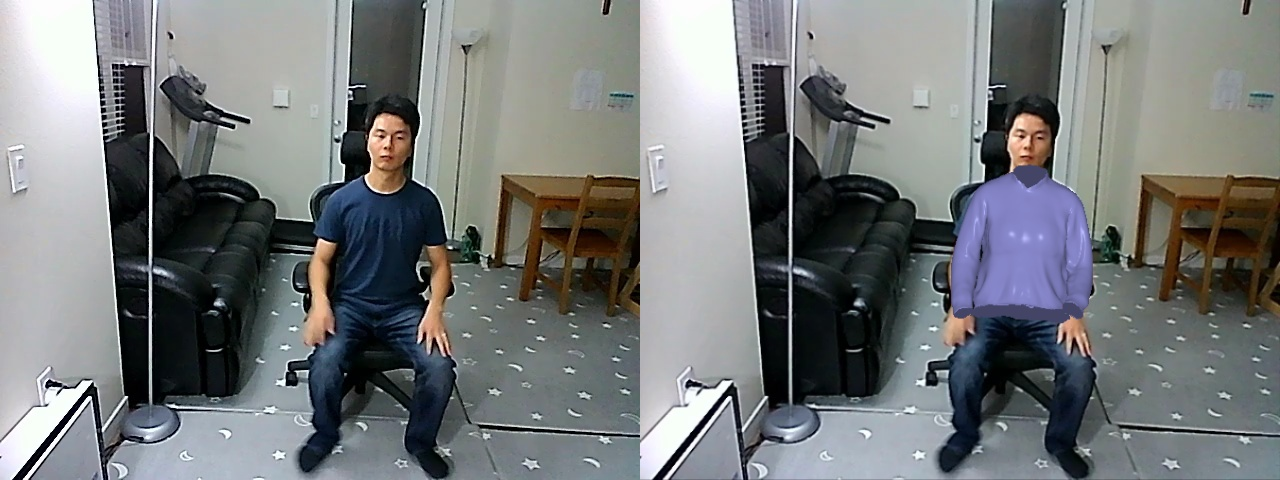

In [31]:
Image('mocap_output/rendered/00000.jpg')

In [34]:
garment_tex

'../Multi-Garment_dataset/125611509120749/multi_tex.jpg'

In [ ]:
res_img_buffer = res_img.copy()
rend_img = np.ones((1920, 1920, 3))
h, w = res_img.shape[:2]
rend_img[:h, :w, :] = res_img

for mesh in pred_mesh_list:
    verts = mesh['vertices']
    faces = mesh['faces']
    rend_img = self.renderer.render(verts, faces, rend_img)

res_img1 = rend_img[:h, :w, :]

In [ ]:
res_img = np.concatenate((res_img, rend_img), axis=1)